In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller

In [2]:
# Load dataset
df = pd.read_csv('data/ts2024.csv', parse_dates=['DateTime'])

# Display initial info
print("Initial dataset info:")
print(df.info())
print(df.describe())

Initial dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17544 entries, 0 to 17543
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   DateTime  17544 non-null  object 
 1   Date      17544 non-null  object 
 2   Hour      17544 non-null  int64  
 3   X         16800 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 548.4+ KB
None
               Hour             X
count  17544.000000  16800.000000
mean      11.500000      0.046320
std        6.922384      0.048945
min        0.000000      0.000000
25%        5.750000      0.018200
50%       11.500000      0.036800
75%       17.250000      0.053800
max       23.000000      0.450000


In [3]:
# Check for missing and zero values
missing = df.isna().sum()
zeros = (df['X'] == 0).sum()
print(f"Missing values:\n{missing}")
print(f"Zero values in 'X': {zeros}")

Missing values:
DateTime      0
Date          0
Hour          0
X           744
dtype: int64
Zero values in 'X': 107


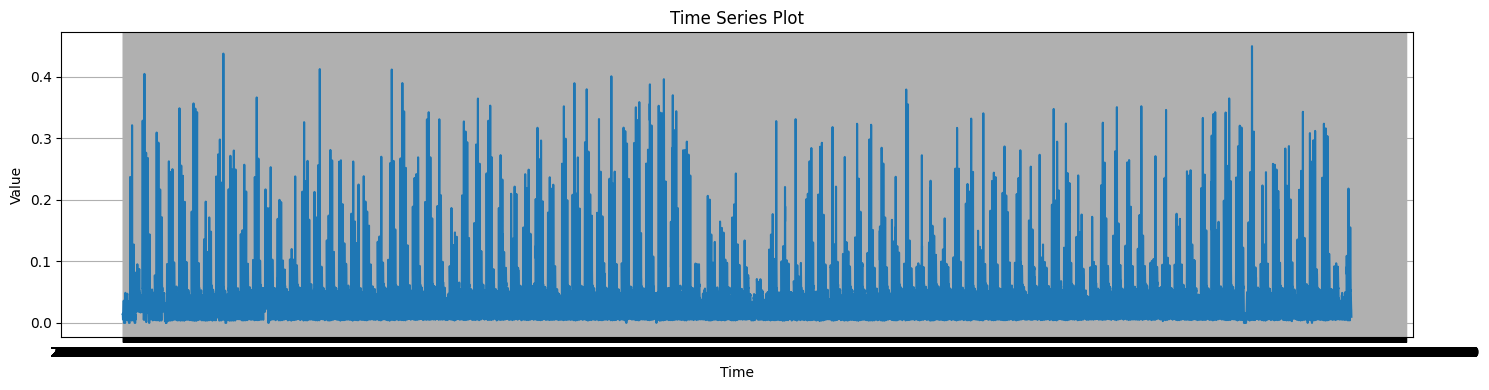

In [4]:
# Plot the time series
plt.figure(figsize=(15, 4))
plt.plot(df['DateTime'], df['X'])
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

# Fast interactive plot with Plotly
fig = px.line(df, x='DateTime', y='X', title="Time Series Plot")
fig.update_layout(xaxis_title="Time", yaxis_title="Value")
fig.show()

In [5]:
# Replace zero values with 24-hour median
def replace_zeros_with_moving_median(series, window=24):
    zero_indices = series[series == 0].index
    for idx in zero_indices:
        left = max(0, idx - window // 2)
        right = min(len(series), idx + window // 2)
        median_val = series[left:right].median()
        series.at[idx] = median_val
    return series

df['X'] = replace_zeros_with_moving_median(df['X'])

In [6]:
# Handle outliers: replace > 99th percentile with median
threshold = df['X'].quantile(0.99)
df.loc[df['X'] > threshold, 'X'] = df['X'].median()

In [ ]:
# Plot the time series
plt.figure(figsize=(15, 4))
plt.plot(df['DateTime'], df['X'])
plt.title("Time Series Plot")
plt.xlabel("Time")
plt.ylabel("Value")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import plotly.express as px

# Fast interactive plot with Plotly
fig = px.line(df, x='DateTime', y='X', title="Time Series Plot")
fig.update_layout(xaxis_title="Time", yaxis_title="Value")
fig.show()

In [ ]:
# Plot ACF and PACF
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df['X'], ax=ax[0], lags=50)
ax[0].set_title('Autocorrelation Function (ACF)')
plot_pacf(df['X'], ax=ax[1], lags=50, method='ywm')
ax[1].set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()
plt.show()